# House Pricing Model Machine Learning
Build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Backgroud:
Model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.
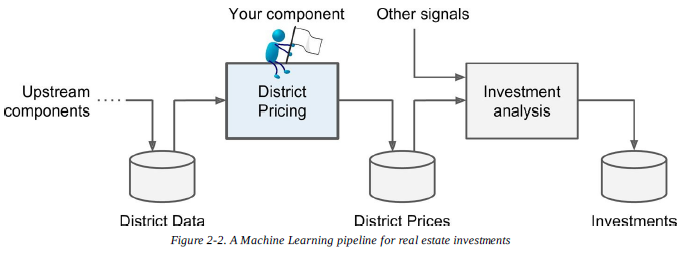

The district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district (excluding median housing prices), and they use complex rules to come up with an estimate. This is costly and time-consuming, and their estimates are not great; their typical error rate is about 15%.

### Type of Machine Learning
It is clearly a typical supervised learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price).

It is also a typical regression task, since you are asked to predict a value.

This is a multivariate regression problem since it will use multiple features to make a prediction (it will use the district’s population, the median income, etc.)

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import hashlib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Understanding the Data

#### Fetching and Loading Data set
Provide the path, extract the tar file which will give csv file

Load the csv file and display first few rows

In [2]:
# Define tar file path for Housing data
HOUSING_PATH = "C:/Users/ajana/Desktop/DSP/DSP Projects/Datasets/Housing/"

def fetch_housing_data(housing_url=HOUSING_PATH):
    tgz_path = os.path.join(housing_url, "housing.tgz")
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_url)
    housing_tgz.close()

def load_housing_data(housing_url=HOUSING_PATH):
    csv_path = os.path.join(housing_url, "housing.csv")
    return pd.read_csv(csv_path)

# Where to save the figures
HOUSING_IMAGE_PATH = os.path.join(HOUSING_PATH, "Images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(HOUSING_IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
fetch_housing_data()
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Metadata of Data
Let's look into various attributes and their datatypes

In [4]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows,
# and each attribute’s type and number of non-null values

housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Categorical Attributes
Let's look into various values of categorical attributes and their frequency

In [5]:
# value_counts() method can be used to identify the categories and how many disctricts belong to each category

housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Numerical Attributes
Let's look into basic statistics of numerical attributes like mean, standard deviation, min/max, count of instances, etc.

In [6]:
# The describe() method shows a summary of the numerical attributes

housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Histogram for Numerical Attributes
Distribution of numerical values for each numerical attribute

Saving figure attribute_histogram_plots


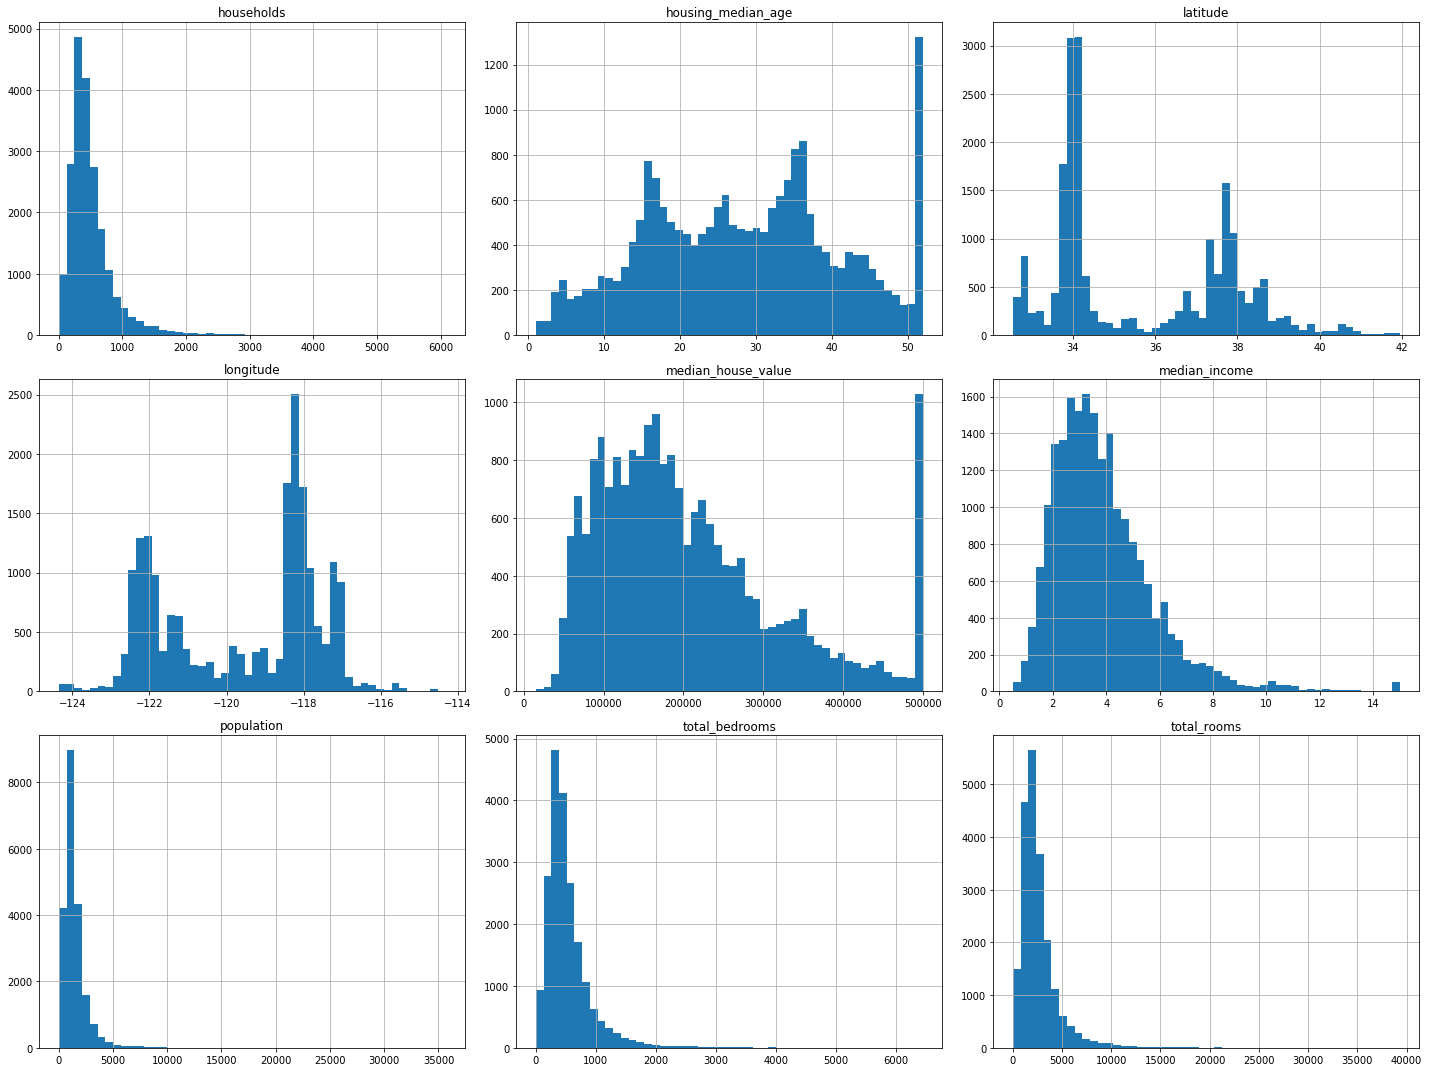

In [7]:
# Quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute

%matplotlib inline
housing_data.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### Corelation
relation between 2 variables and ranges between -1 and 1

In [8]:
# compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using corr() method
corr_matrix = housing_data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


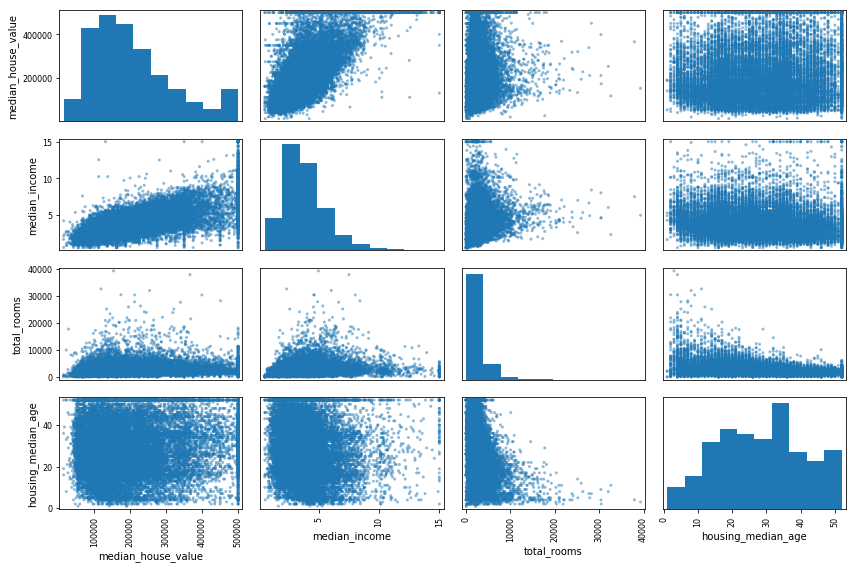

In [9]:
# Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function,
# which plots every numerical attribute against every other numerical attribute
# Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page
# So, let’s just focus on a few promising attributes that seem most correlated with the median housing value

# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [10]:
# Experimenting with Attribute Combinations
housing_data_exp = housing_data.copy()
housing_data_exp["rooms_per_household"] = housing_data_exp["total_rooms"]/housing_data_exp["households"]
housing_data_exp["bedrooms_per_room"] = housing_data_exp["total_bedrooms"]/housing_data_exp["total_rooms"]
housing_data_exp["population_per_household"] = housing_data_exp["population"]/housing_data_exp["households"]

### Discover and visualize the data to gain insights

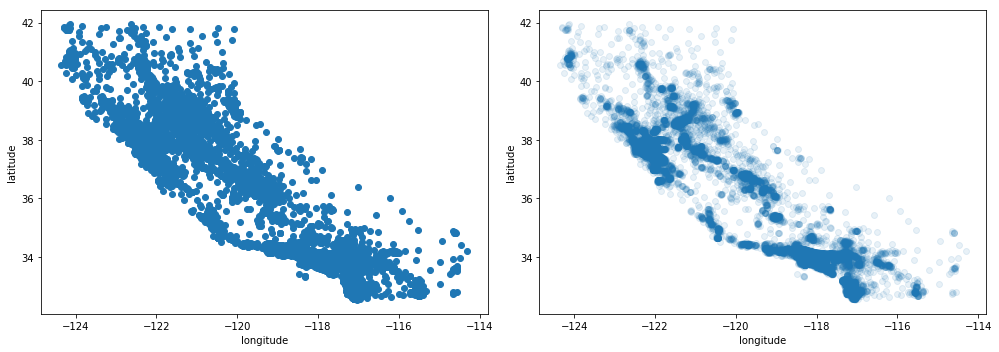

In [12]:
fig = plt.figure(figsize=(14,5))

# scatterplot of all districts to visualize the data
plt.subplot(1,2,1)
plt.scatter(x=housing_data['longitude'], y=housing_data['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')

# Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points
plt.subplot(1,2,2)
plt.scatter(x=housing_data['longitude'], y=housing_data['latitude'], alpha=0.1)
plt.xlabel('longitude')
plt.ylabel('latitude')

fig.tight_layout()
plt.show()

Saving figure housing_prices_scatterplot


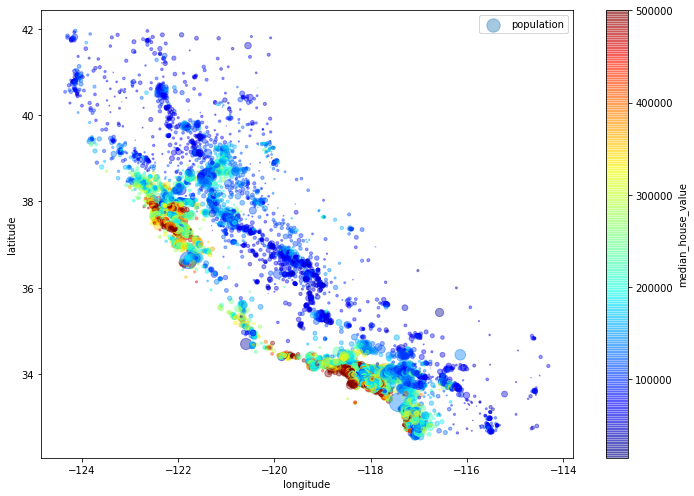

In [15]:
# Housing prices per district area
# The radius of each circle represents the district’spopulation (option s), and the color represents the price (option c)
# Use predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_data["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

This image tells that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density

It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well.

In [16]:
# Correlation Matrix with new experimented attributes
corr_matrix = housing_data_exp.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

### Create Train and Test Data set
Before you look at the data any further, you need to create a test set, put it aside, and never look at it. Machine Learning Algorithm model should be trained used train data set and test data set should be used to check the performance of the model

Usually, 20% of the entire population is taken as test dataset.

### Two ways of splitting Data set - Random & Stratified
Random - Randomly split the dataset, however, this can cause sampling bias. Example, Election, Surveys, etc.

Stratified - Consider ratio of the samples like male/female, job designation, income class, etc. This is called Stratified sampling, where the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

##### Correlation of Median Income is high aginst Median House Value
Hence, we will use Median Income for stratififed split of dataset

In [17]:
# Splitting the dataset into training and testing set 
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)

# Print number of instances for train and test dataset
print("Random Sampling: ", len(train_set), "train +", len(test_set), "test")

Random Sampling:  16512 train + 4128 test


In [18]:
# It is important to have a sufficient number of instances in your dataset for each stratum,
# or else the estimate of the stratum’s importance may be biased.
# This means that you should not have too many strata, and each stratum should be large enough.

# Divide by 1.5 to limit the number of income categories
housing_data["income_cat"] = np.ceil(housing_data["median_income"] / 1.5)

# Label those above 5 as 5
housing_data["income_cat"].where(housing_data["income_cat"] < 5, 5.0, inplace=True)

In [19]:
# Stratified sampling based on the income category.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

# Print number of instances for train and test dataset
print("Stratified Sampling: ", len(strat_train_set), "train +", len(strat_test_set), "test")

Stratified Sampling:  16512 train + 4128 test


In [20]:
# remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Prepare the data for Machine Learning algorithms

ML takes input as numeric values

In [21]:
# Separate the Predictors and the Labels
# Since we don’t necessarily want to apply the same transformations to the predictors and the target values
housing_train_set = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

#### Transform Null / Missing Values

In [22]:
# Data Cleaning Process - Get null value rows
sample_incomplete_rows = housing_train_set[housing_train_set.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [23]:
# Option 1 - Remove rows where total_bedrooms has null values
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [24]:
# Option 2 - Remove the column completely if not relevant
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [25]:
# Option 3 - Set null values to median values of whole total_bedrooms values
median = housing_train_set["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [26]:
# We will go with option 3 to fill the missing values in the training set with median values.
# median can only be computed on numerical attributes using Imputer class

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing_train_set.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

# The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.
# Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data
# after the system goes live, so it is safer to apply the imputer to all the numerical attributes

#imputer.statistics_

# Re-check that this is the same as manually computing the median of each attribute:
#housing_num.median().values

# Now use this “trained” imputer to transform the training set by replacing missing values by the learned medians
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing_train_set.index.values))
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


#### Transform Categorical Values

In [27]:
# categorical attribute ocean_proximity is a text attribute so we cannot compute its median.
# Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these text labels to numbers.

housing_cat = housing_train_set['ocean_proximity']
housing_cat.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [28]:
# LabelEncoder feature can transform string categorical feature to an integer categorical feature

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing_train_set["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat.value_counts())
print(housing_cat_encoded[:10])
print(np.array(housing_cat[:10]))

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64
[0 0 4 1 0 1 0 1 0 0]
['<1H OCEAN' '<1H OCEAN' 'NEAR OCEAN' 'INLAND' '<1H OCEAN' 'INLAND'
 '<1H OCEAN' 'INLAND' '<1H OCEAN' '<1H OCEAN']


In [29]:
# One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.
# Obviously this is not the case (for example, categories 0 and 4 are more similar than categories 0 and 1).
# To fix this issue, a common solution is to create one binary attribute per category:
# one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1
# when the category is “INLAND” (and 0 otherwise), and so on.
# This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

# OneHotEncoder encoder to convert integer categorical values into one-hot vectors.
# Let’s encode the categories as one-hot vectors.
# Note that fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

# We can apply both transformations (from text categories to integer categories, 
# then from integer categories to one-hot vectors) in one shot using the LabelBinarizer class

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [30]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [31]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

# Alternatively, you can specify the encoding to be "onehot-dense" to get a dense matrix rather than a sparse matrix:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

### Feature Engineering - Add extra parameters to train data set

In [32]:
# Let's create a custom transformer to add extra attributes:

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [33]:
# This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not.
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_train_set.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing_train_set.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Feature Scaling
One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason.

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0– 0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization.

Note: As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

### Transformation Pipelines
Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [34]:
# And a transformer to just select a subset of the Pandas DataFrame columns:

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [35]:
# Let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing_train_set)

## Select & Train the Model

Typical performance measure for Regression models
Root Mean Square Error (RMSE) - It measures the standard deviation of the errors the system makes in its predictions.

Suppose that there are many outlier districts. In that case, you may consider using the Mean Absolute Error (also called the Average Absolute Deviation)

RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.

## Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

print("Prediction Labels:", lin_reg.predict(housing_prepared[:5]))

# Compare against the actual values:
print("Actual Labels:", list(housing_labels[:5]))

Prediction Labels: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Actual Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

In [37]:
# model is working although the predictions are not exactly accurate, Let’s measure this regression model’s RMSE

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print ("Prediction Error", lin_rmse)

Prediction Error 68628.1981985


In [38]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

## Decision Tree Regressor Model

In [39]:

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print ("Prediction Error", tree_rmse)

Prediction Error 0.0


No error at all, absolutely perfect model. Model has badly overfit the data.
Hence, we need to use part of the training set for training, and part for model validation.

In [40]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [41]:
# The following code performs K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds
# then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and
# training on the other 9 folds. The result is an array containing the 10 evaluation scores:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print ("Cross Validation - Decision Tree Regressor")
display_scores(tree_rmse_scores)

Cross Validation - Decision Tree Regressor
Scores: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean: 71379.0744771
Standard Deviation: 2458.31882043


In [42]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print ("Cross Validation - Linear Regression")
display_scores(lin_rmse_scores)

Cross Validation - Linear Regression
Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard Deviation: 2731.6740018


## Random Forest Regressor Model

In [43]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print ("Prediction Error", forest_rmse)

Prediction Error 21941.9110274


In [44]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print ("Cross Validation - Random Forest Regressor")
display_scores(forest_rmse_scores)

Cross Validation - Random Forest Regressor
Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard Deviation: 2301.87380392


### Prediction Error Comparison

In [45]:
print ("Predition Error of each Model through RMSE")
print ("Linear Regression:       ", lin_rmse)
print ("Decision Tree Regressor: ", tree_rmse)
print ("Random Forest Regressor: ", forest_rmse)

Predition Error of each Model through RMSE
Linear Regression:        68628.1981985
Decision Tree Regressor:  0.0
Random Forest Regressor:  21941.9110274


### Cross Validation Comparison

In [46]:
print ("Cross Validation Scores of each Model")
print ("Linear Regression       - Prediction Error Mean: ", lin_rmse_scores.mean(), "     Std: ", lin_rmse_scores.std())
print ("Decision Tree Regressor - Prediction Error Mean: ", tree_rmse_scores.mean(), "     Std: ", tree_rmse_scores.std())
print ("Random Forest Regressor - Prediction Error Mean: ", forest_rmse_scores.mean(), "     Std: ", forest_rmse_scores.std())

Cross Validation Scores of each Model
Linear Regression       - Prediction Error Mean:  69052.4613635      Std:  2731.6740018
Decision Tree Regressor - Prediction Error Mean:  71379.0744771      Std:  2458.31882043
Random Forest Regressor - Prediction Error Mean:  52564.1902524      Std:  2301.87380392


## Prepare Test Data for ML

In [47]:
# Separate the Predictors and the Labels
housing_test_set = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

imputer = Imputer(strategy="median")

# Remove the text attribute because median can only be calculated on numerical attributes:
housing_test_num = housing_test_set.drop('ocean_proximity', axis=1)

# Apply median values to fill null values
imputer.fit(housing_test_num)

#Transform Categorical values to numerical values
housing_test_cat = housing_test_set['ocean_proximity']

from sklearn.preprocessing import LabelBinarizer
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_test_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

# Feature Enggineering by adding additional attributes
housing_test_extra_attribs = attr_adder.transform(housing_test_set.values)
housing_test_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing_test_set.columns)+["rooms_per_household", "population_per_household"])

num_test_attribs = list(housing_test_num)
cat_test_attribs = ["ocean_proximity"]

num_test_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_test_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_test_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_test_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

from sklearn.pipeline import FeatureUnion

full_test_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_test_pipeline),
        ("cat_pipeline", cat_test_pipeline),
    ])

housing_test_prepared = full_pipeline.fit_transform(housing_test_set)

### Use Random Forest Regressor Model to Predict Median House Value on Test Data

In [48]:
housing_test_predictions = forest_reg.predict(housing_test_prepared)
print('Predicted Values: ', housing_test_predictions[:5])
print('Actual Values   : ', list(housing_test_labels.iloc[:5]))

Predicted Values:  [ 470120.4  435780.3  253200.1  207510.   136980. ]
Actual Values   :  [500001.0, 240300.0, 218200.0, 182100.0, 121300.0]
